In [79]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import torch
from torch.utils.data import DataLoader

import src.training as training
import src.models as models

from importlib import reload
reload(training)
reload(models)

<module 'src.models' from '/home/b7009348/CosyMAML/src/models.py'>

[0.16697294 0.61361168 1.        ] (5, 300) (5, 300)


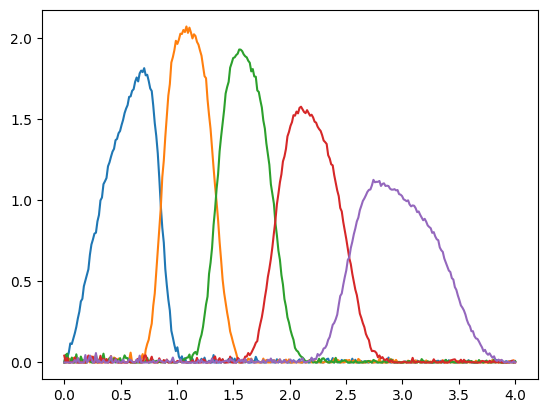

In [80]:
# Select a task to run for the MCMC sampler
filepath = 'data/1000tasks_5000samples_44seed.h5'
i=144
with h5.File(filepath, 'r') as f:
    dndz_mcmc = f['dndz'][i]
    z = f['z'][i]
    dndz_params = f['dndz_params'][i]

print(dndz_params, dndz_mcmc.shape, z.shape)
for i in range(dndz_mcmc.shape[0]):
    plt.plot(z[i], dndz_mcmc[i])

In [ ]:
# Load the data and construct a dataloader
filepath = 'data/1000tasks_5000samples_14seed.h5'
dataset = training.HDF5Dataset(filepath)
dataloader = DataLoader(dataset, batch_size=20, shuffle=True)

# Load the model
model = models.FastWeightCNN(
    input_size=10,
    latent_dim=(16,16),
    output_size=750,
    dropout_rate=0.2
)

# Initialise a MetaLearner
metalearner = training.MetaLearner(
    model=model,
    outer_lr=0.01,
    inner_lr=0.001,
    loss_fn=torch.nn.MSELoss,
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-8,
    seed=14,
    device='cuda'
)

# Train the model
outer_epochs = 400
meta_losses = []

for epoch in range(outer_epochs):
    # Load the data
    x_batch, y_batch = next(iter(dataloader))
    x_batch = x_batch.to(metalearner.device) # Move to GPU if available
    y_batch = y_batch.to(metalearner.device)

    # Take logarithm of y_batch
    y_batch = torch.log(y_batch)

    # Split the data into support and query sets
    x_spt, y_spt, x_qry, y_qry = training.support_query_split(
        x_batch, y_batch, spt_frac=0.8
    )

    # Perform one meta update step across the batch
    meta_loss = metalearner.meta_train(
        x_spt, y_spt, x_qry, y_qry, inner_steps=5
    )
    
    meta_losses.append(meta_loss)
    print(f'Epoch {epoch+1}/{outer_epochs} - Meta Loss: {meta_loss}')

plt.plot(meta_losses)

Epoch 1/400 - Meta Loss: 0.4978124797344208
Epoch 2/400 - Meta Loss: 0.884137749671936
Epoch 3/400 - Meta Loss: 0.5177653431892395
Epoch 4/400 - Meta Loss: 0.3141649663448334
Epoch 5/400 - Meta Loss: 0.19253650307655334
Epoch 6/400 - Meta Loss: 0.1477239578962326
Epoch 7/400 - Meta Loss: 0.13456566631793976
Epoch 8/400 - Meta Loss: 0.1225576177239418
Epoch 9/400 - Meta Loss: 0.1381179243326187
Epoch 10/400 - Meta Loss: 0.1534794121980667
Epoch 11/400 - Meta Loss: 0.1484953612089157
Epoch 12/400 - Meta Loss: 0.12522175908088684
Epoch 13/400 - Meta Loss: 0.11434724181890488
Epoch 14/400 - Meta Loss: 0.10179173201322556
Epoch 15/400 - Meta Loss: 0.09676925837993622
Epoch 16/400 - Meta Loss: 0.10216542333364487
Epoch 17/400 - Meta Loss: 0.09075426310300827
Epoch 18/400 - Meta Loss: 0.09004922956228256
Epoch 19/400 - Meta Loss: 0.08780433237552643
Epoch 20/400 - Meta Loss: 0.09612219780683517
Epoch 21/400 - Meta Loss: 0.13865797221660614
Epoch 22/400 - Meta Loss: 0.11460267752408981
Epoch 2